# Grass growth model evaluation

In [169]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error
import geopandas as gpd
import numpy as np

In [4]:
# read time series of grass growth
grass_pbi = pd.read_csv(
    os.path.join(
        "data", "grass_growth", "PastureBaseIreland", "pasturebase_cleaned.csv"
    )
)
grass_gcni = pd.read_csv(
    os.path.join(
        "data", "grass_growth", "GrassCheckNI", "grasscheck_cleaned.csv"
    )
)
mera = pd.read_csv(
    os.path.join("data", "ModVege", "growth", "MERA_growth_week_pasture.csv")
)

In [5]:
mera = mera.set_index("time")
mera.index = pd.to_datetime(mera.index)
mera.rename(columns={"COUNTY": "county", "mean": "value"}, inplace=True)
mera["county"] = mera["county"].str.title()
mera = mera["2013":"2018"]

In [7]:
grass = pd.concat([grass_pbi, grass_gcni])
grass = pd.pivot_table(
    grass[["time", "county", "value"]],
    values="value",
    index=["time"],
    columns=["county"],
)
grass.index = pd.to_datetime(grass.index)
grass = grass["2013":"2018"]
grass = grass.melt(ignore_index=False)

In [9]:
# label measured and simulated data and merge
grass["data"] = "Measured"
mera["data"] = "Simulated"
data_all = pd.concat([grass, mera])

In [11]:
data_all["weekno"] = data_all.index.isocalendar().week
data_all["doy"] = data_all.index.dayofyear
data_all["year"] = data_all.index.year

In [16]:
data_all.dropna(inplace=True)

In [18]:
data_all

,county,value,data,weekno,doy,year
time,,,,,,
2017-04-03,Antrim,17.700000,Measured,14,93,2017
2017-04-10,Antrim,30.000000,Measured,15,100,2017
2017-04-17,Antrim,54.800000,Measured,16,107,2017
2017-04-24,Antrim,52.000000,Measured,17,114,2017
2017-05-01,Antrim,35.700000,Measured,18,121,2017
...,...,...,...,...,...,...
2018-12-31,Antrim,0.779210,Simulated,1,365,2018
2018-12-31,Armagh,0.861603,Simulated,1,365,2018
2018-12-31,Fermanagh,1.025990,Simulated,1,365,2018


In [159]:
data_all.describe()[["value"]]

,value
count,14298.000000
mean,32.970445
min,0.000000
25%,4.590000
50%,27.875072
75%,57.867500
max,124.310000
std,28.749976


In [160]:
data_all.groupby(["county", "data"]).describe()[["value"]]

value                                             \
                     count       mean       min        25%        50%   
county    data                                                          
Carlow    Measured   276.0  35.096232  0.000000  13.952500  36.950000   
          Simulated  313.0  23.131156  0.000000   0.816741  11.259532   
Cavan     Measured   286.0  35.550734  0.000000   9.340000  35.370000   
          Simulated  313.0  33.727190  0.000000   0.951754  16.924116   
Clare     Measured   288.0  37.401736  1.020000  10.457500  39.225000   
          Simulated  313.0  30.115779  0.064351   1.775048  20.827829   
Cork      Measured   312.0  37.146410  0.000000  11.520000  37.095000   
          Simulated  313.0  26.326234  0.047661   1.450293  13.838315   
Donegal   Measured   243.0  42.909506  0.000000  16.830000  48.610000   
          Simulated  313.0  30.033467  0.000005   0.903567  15.409813   
Galway    Measured   294.0  38.308248  0.000000  11.945000  41.645000   
          Simulated  313.0  32.254848  0.007288   1.468384  20.320453   
Kerry     Measured   283.0  38.764240  0.000000  11.940000  40.710000   
          Simulated  313.0  30.683545  0.138996   2.116173  22.303822   
Kildare   Measured   289.0  39.393616  0.000000  14.130000  39.430000   
          Simulated  313.0  25.866932  0.000000   0.881257  11.615354   
Kilkenny  Measured   307.0  35.683257  0.000000  10.680000  35.160000   
          Simulated  313.0  24.073635  0.000000   0.916919  12.437414   
Laois     Measured   303.0  35.497327  0.520000  10.660000  37.300000   
          Simulated  313.0  24.714538  0.000000   0.703398  11.186044   
Limerick  Measured   302.0  35.110579  0.000000  10.150000  36.300000   
          Simulated  313.0  29.123979  0.000126   1.289842  17.296220   
Longford  Measured   268.0  45.507090  0.000000  18.725000  51.105000   
          Simulated  313.0  33.401473  0.000000   1.059137  17.351267   
Louth     Measured   294.0  38.917908  0.000000  12.090000  39.140000   
          Simulated  313.0  23.594207  0.000000   0.828635  11.328886   
Mayo      Measured   269.0  38.885093  0.000000  10.380000  41.630000   
          Simulated  313.0  35.445430  0.005365   1.500143  23.502917   
Meath     Measured   298.0  37.262819  0.000000  10.921250  37.720000   
          Simulated  313.0  26.875765  0.000000   0.851106  12.583754   
Monaghan  Measured   270.0  39.209259  1.360000  10.070000  44.620000   
          Simulated  313.0  30.931272  0.000000   0.792958  13.132411   
Offaly    Measured   279.0  37.777384  0.360000  15.160000  40.240000   
          Simulated  313.0  25.444796  0.000000   0.823603  12.114419   
Roscommon Measured   221.0  38.836154  0.000000  15.900000  41.440000   
          Simulated  313.0  34.033309  0.000000   1.082128  18.126018   
Sligo     Measured   261.0  37.193295  1.390000  13.330000  40.420000   
          Simulated  313.0  38.249012  0.000000   1.440413  22.901354   
Tipperary Measured   310.0  36.349984  1.845000   9.847500  35.920000   
          Simulated  313.0  27.621946  0.000000   1.087953  15.074609   
Waterford Measured   310.0  34.826048  0.000000   9.625000  34.345000   
          Simulated  313.0  23.738835  0.002250   1.196338  13.169288   
Westmeath Measured   265.0  38.540415  0.000000  14.220000  42.080000   
          Simulated  313.0  29.763322  0.000000   0.989116  14.580233   
Wexford   Measured   293.0  37.493038  0.000000  13.470000  38.770000   
          Simulated  313.0  22.001784  0.001681   1.028372  12.110271   
Wicklow   Measured   265.0  39.090604  0.960000  13.040000  40.620000   
          Simulated  313.0  24.459046  0.000000   0.708889  10.562476   

                                                       
                           75%         max        std  
county    data                                         
Carlow    Measured   52.710000   83.540000  22.153431  
          Simulated  44.458806   89.519063  25.674030  
Cavan     Measure

## Comparison

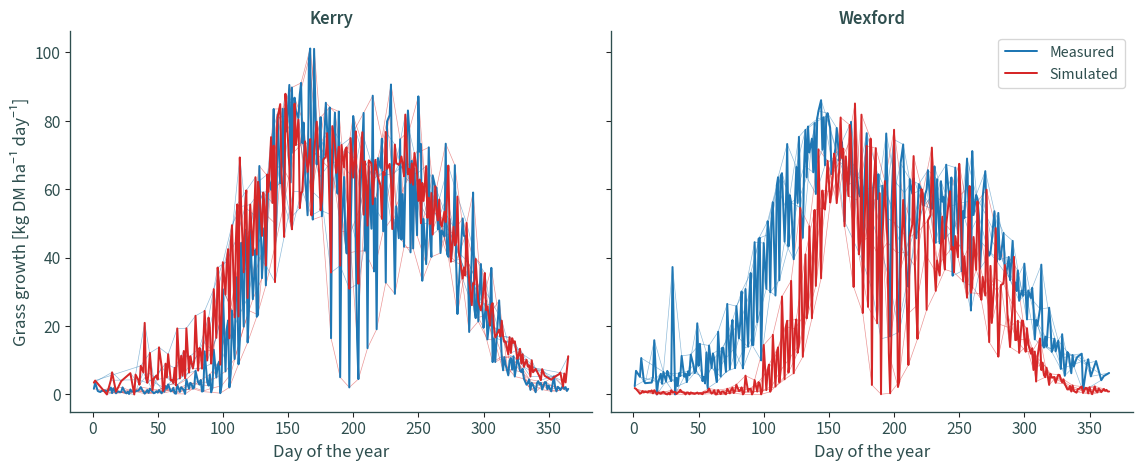

In [19]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
for n, (c, l) in enumerate(zip(["Kerry", "Wexford"], [False, True])):
    for year in list(set(data_all["year"])):
        sns.lineplot(data=data_all[(data_all["county"] == c) & (data_all["year"] == year)].reset_index(), x="doy", y="value", hue="data", errorbar=("pi", 100), ax=ax[n], legend=False, palette=sns.color_palette(["tab:blue", "tab:red"]), lw=0.5, alpha=.5)
    sns.lineplot(data=data_all[data_all["county"] == c].drop(columns=["county"]).groupby(["doy", "data"]).mean().sort_values(by=["doy"]), x="doy", y="value", hue="data", errorbar=("pi", 100), ax=ax[n], legend=l, palette=sns.color_palette(["tab:blue", "tab:red"]))
    ax[n].set_title(c)
    ax[n].set_xlabel("Day of the year")
    ax[n].set_ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
plt.legend(title=None, fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

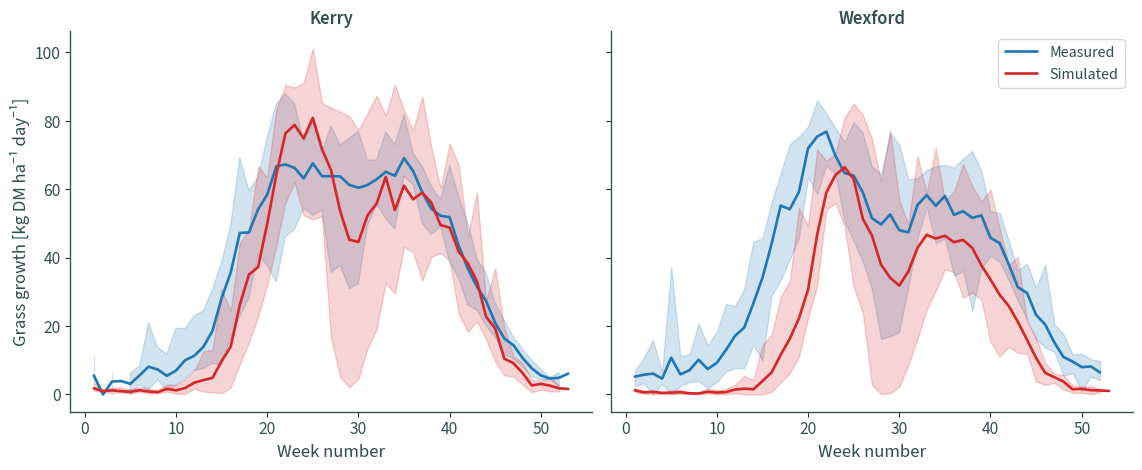

In [17]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
for n, (c, l) in enumerate(zip(["Kerry", "Wexford"], [False, True])):
    sns.lineplot(data=data_all[data_all["county"] == c].reset_index(), x="weekno", y="value", hue="data", errorbar=("pi", 100), ax=ax[n], legend=l, palette=sns.color_palette(["tab:blue", "tab:red"]), lw=2)
    ax[n].set_title(c)
    ax[n].set_xlabel("Week number")
    ax[n].set_ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
plt.legend(title=None, fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

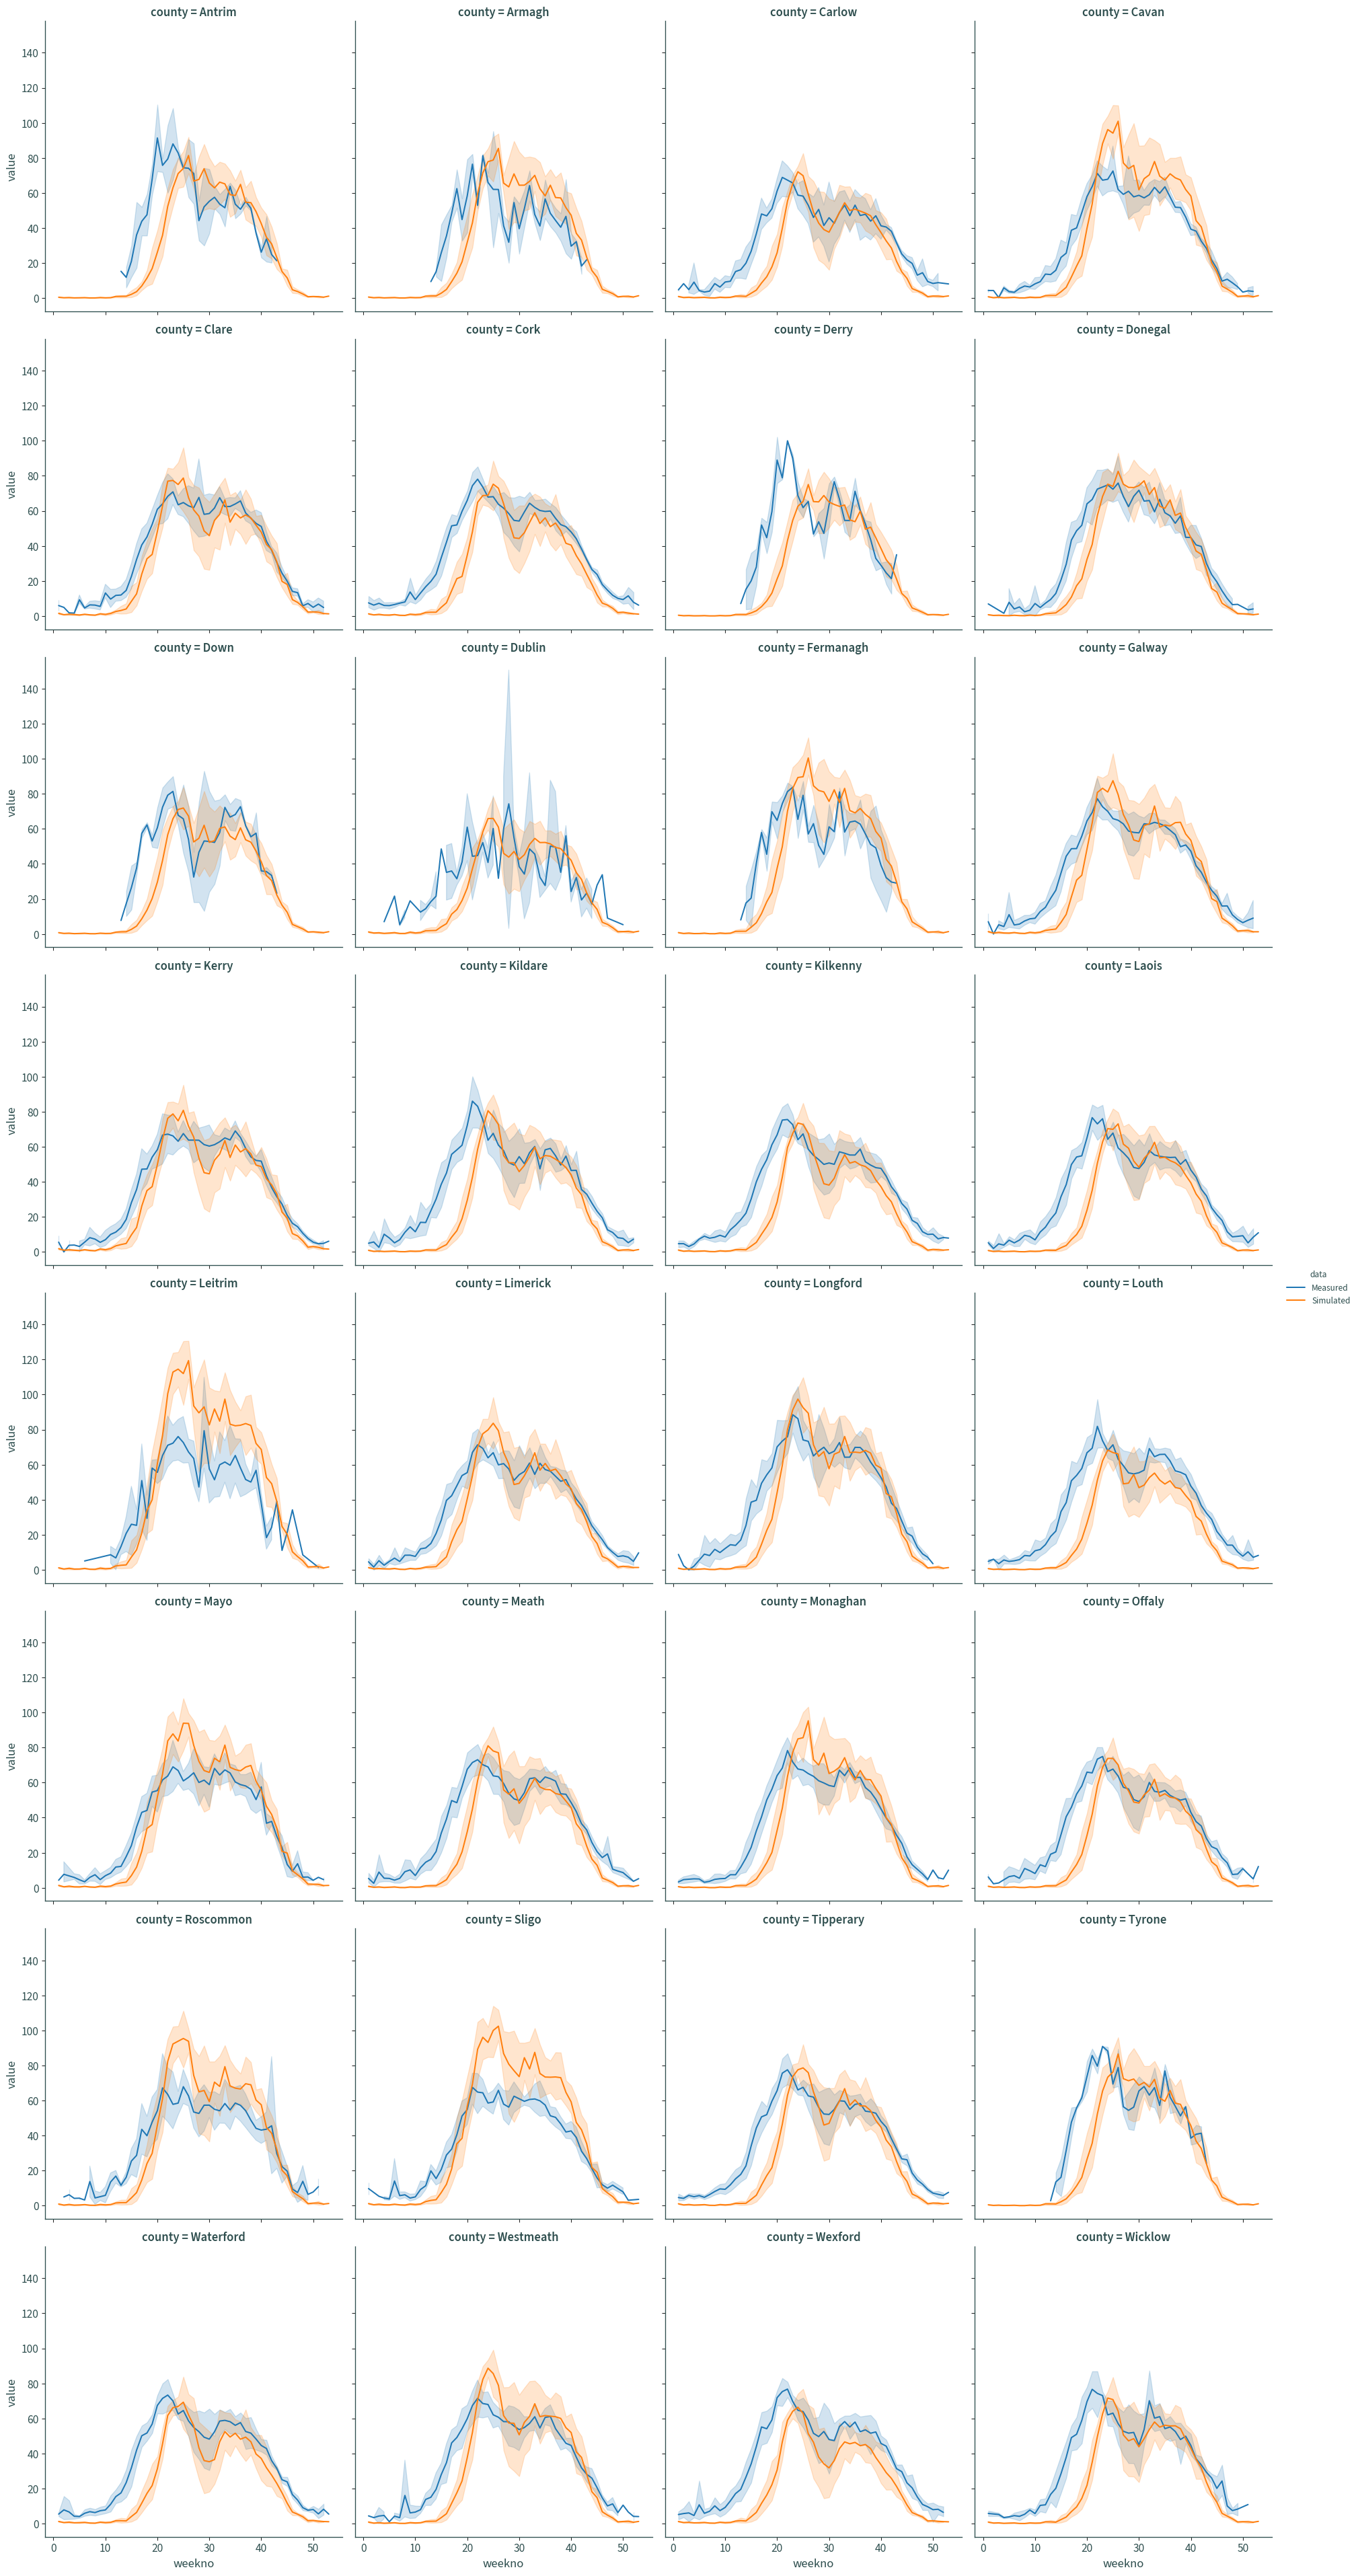

In [102]:
sns.relplot(data=data_all.reset_index(), x="weekno", y="value", hue="data", col="county", col_wrap=4, kind="line")
plt.show()

## RMSE

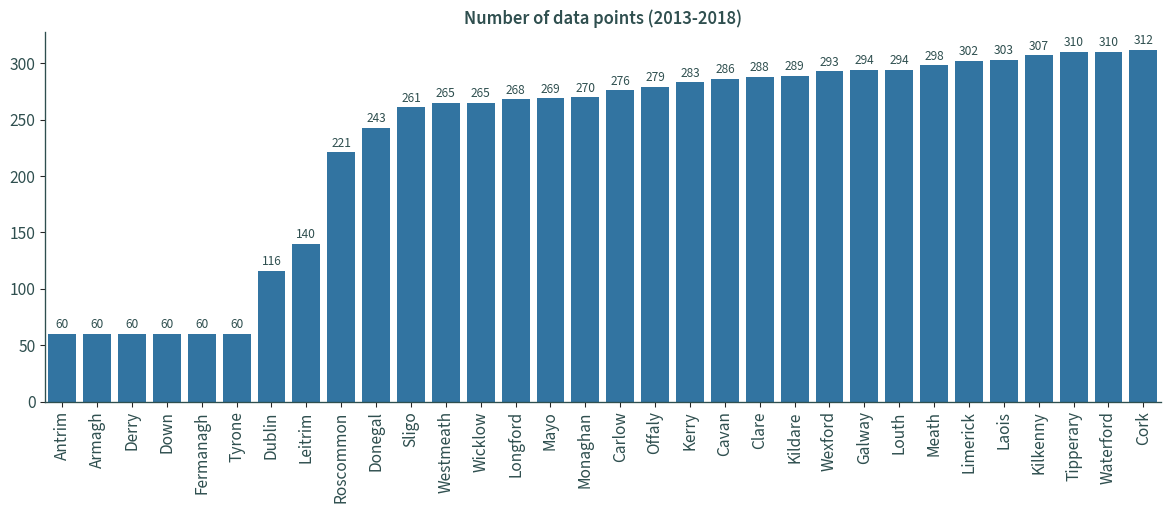

In [53]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=grass.dropna().groupby("county").count().sort_values(["value"]).reset_index(), x="county", y="value")
ax.bar_label(ax.containers[0], padding=2)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None)
plt.title("Number of data points (2013-2018)")
sns.despine()
plt.show()

In [62]:
data_pivot = pd.pivot_table(
    data_all.reset_index()[["time", "county", "value", "data"]],
    values="value",
    index=["county", "time"],
    columns=["data"],
).reset_index()

In [65]:
data_pivot.dropna(inplace=True)

In [93]:
counties = list(set(data_pivot["county"])) + ["All"]

In [94]:
rmse_counties = {}

In [95]:
for c in counties:
    if c == "All":
        rmse_counties[c] = root_mean_squared_error(data_pivot["Measured"], data_pivot["Simulated"])
    else:
        dc = data_pivot[data_pivot["county"] == c]
        rmse_counties[c] = root_mean_squared_error(dc["Measured"], dc["Simulated"])

In [96]:
rmse_counties = pd.DataFrame(rmse_counties, index=[0]).transpose().sort_values(by=[0]).reset_index(inplace=True)

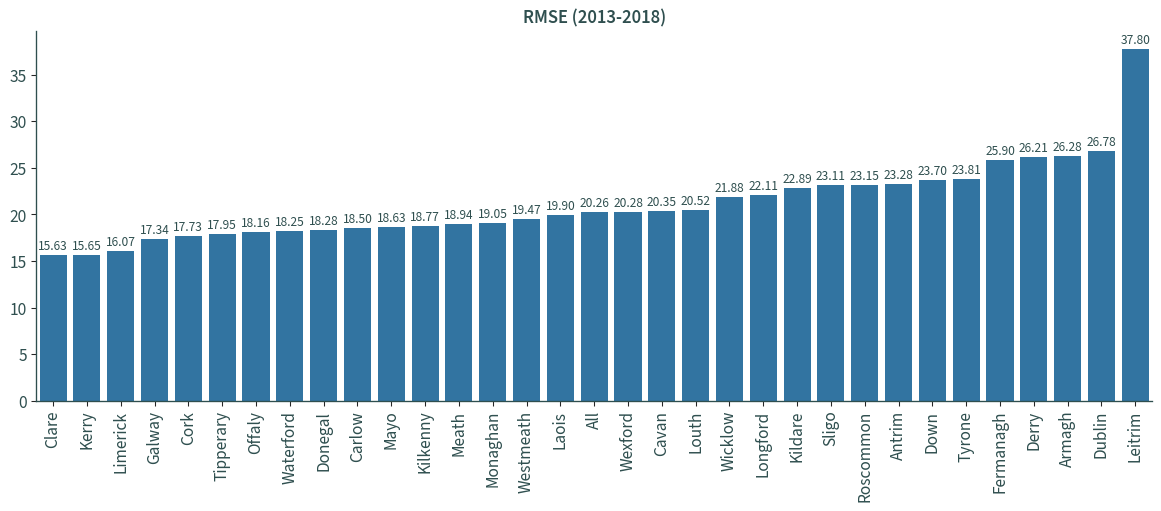

In [106]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=rmse_counties, x="index", y=0)
ax.bar_label(ax.containers[0], padding=2, fmt="{:.2f}")
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None)
plt.title("RMSE (2013-2018)")
sns.despine()
plt.show()

In [121]:
# drop counties with < 200 points and/or RMSE > 25
for c in ["Antrim", "Armagh", "Derry", "Down", "Fermanagh", "Tyrone", "Dublin", "Leitrim"]:
    data_pivot = data_pivot[data_pivot["county"] != c]

## Regression

In [136]:
x = data_pivot["Measured"]
y = data_pivot["Simulated"]

model = sm.OLS(y, sm.add_constant(x))
results = model.fit()

print(results.summary())

b, m = results.params
r = results.rsquared

                            OLS Regression Results                            
Dep. Variable:              Simulated   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                 1.314e+04
Date:                Mon, 29 Jul 2024   Prob (F-statistic):               0.00
Time:                        01:15:27   Log-Likelihood:                -29303.
No. Observations:                6786   AIC:                         5.861e+04
Df Residuals:                    6784   BIC:                         5.862e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.6559      0.398    -16.744      0.0

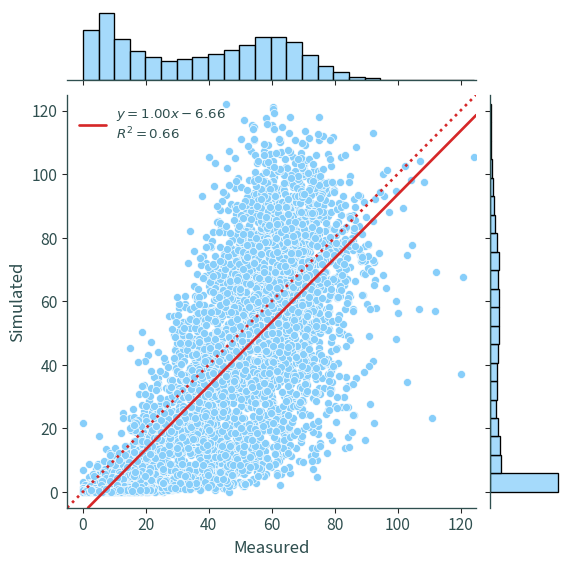

In [180]:
sns.jointplot(data=data_pivot, x="Measured", y="Simulated", color="lightskyblue")
plt.axline((0, 0), slope=1, color="tab:red", linestyle="dotted", linewidth=2)
plt.axline((0, b), slope=m, label=f"$y = {m:.2f}x {b:+.2f}$\n$R^2 = {r:.2f}$", color="tab:red", linewidth=2)
plt.legend(loc="upper left", frameon=False, facecolor=None)
plt.xlim([-5, 125])
plt.ylim([-5, 125])
plt.show()

In [162]:
data_pivot["month"] = data_pivot["time"].dt.month

In [166]:
conditions = [
    data_pivot["month"].isin([12, 1, 2]),
    data_pivot["month"].isin([3, 4, 5]),
    data_pivot["month"].isin([6, 7, 8]),
    data_pivot["month"].isin([9, 10, 11]),
]

In [167]:
choices = ["DJF", "MAM", "JJA", "SON"]

In [172]:
data_pivot["season"] = np.select(conditions, choices)

In [206]:
data_pivot.groupby("season").describe()[["Measured", "Simulated"]].transpose()

season                   DJF          JJA          MAM          SON
data                                                               
Measured  count  1253.000000  1884.000000  1845.000000  1804.000000
          mean      6.542953    60.717765    38.403366    35.127616
          min       0.000000     4.400000     0.000000     0.000000
          25%       3.760000    54.410000    14.500000    19.737500
          50%       5.550000    62.290000    38.190000    35.210000
          75%       8.150000    69.195000    57.890000    49.405000
          max      46.520000   124.310000   120.800000   106.820000
          std       4.653535    13.911997    24.875094    17.614601
Simulated count  1253.000000  1884.000000  1845.000000  1804.000000
          mean      0.745258    64.439311    17.792265    31.594535
          min       0.000000     0.064053     0.000000     0.320922
          25%       0.184382    51.090473     1.039724    11.476733
          50%       0.536290    67.109108     5.837760    29.004848
          75%       1.100322    80.210660    26.819036    49.031414
          max       5.265898   122.056033   110.948637   105.408235
          std       0.729700    23.580598    23.650905    22.585850

In [209]:
data_pivot_season = data_pivot[data_pivot["season"] != "DJF"]

In [212]:
data_pivot_all = data_pivot.copy()
data_pivot_all["season"] = "All"
data_pivot_all = pd.concat([data_pivot_all, data_pivot_season])

In [248]:
def get_regression(data, season):
    df = data[data["season"] == s]
    x = df["Measured"]
    y = df["Simulated"]

    model = sm.OLS(y, sm.add_constant(x))
    results = model.fit()

    print("\n" + "-" * 35, season, "-" * 35)
    print(results.summary())

    b, m = results.params
    r = results.rsquared
    return df, b, m


----------------------------------- All -----------------------------------
                            OLS Regression Results                            
Dep. Variable:              Simulated   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                 1.314e+04
Date:                Mon, 29 Jul 2024   Prob (F-statistic):               0.00
Time:                        02:44:04   Log-Likelihood:                -29303.
No. Observations:                6786   AIC:                         5.861e+04
Df Residuals:                    6784   BIC:                         5.862e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

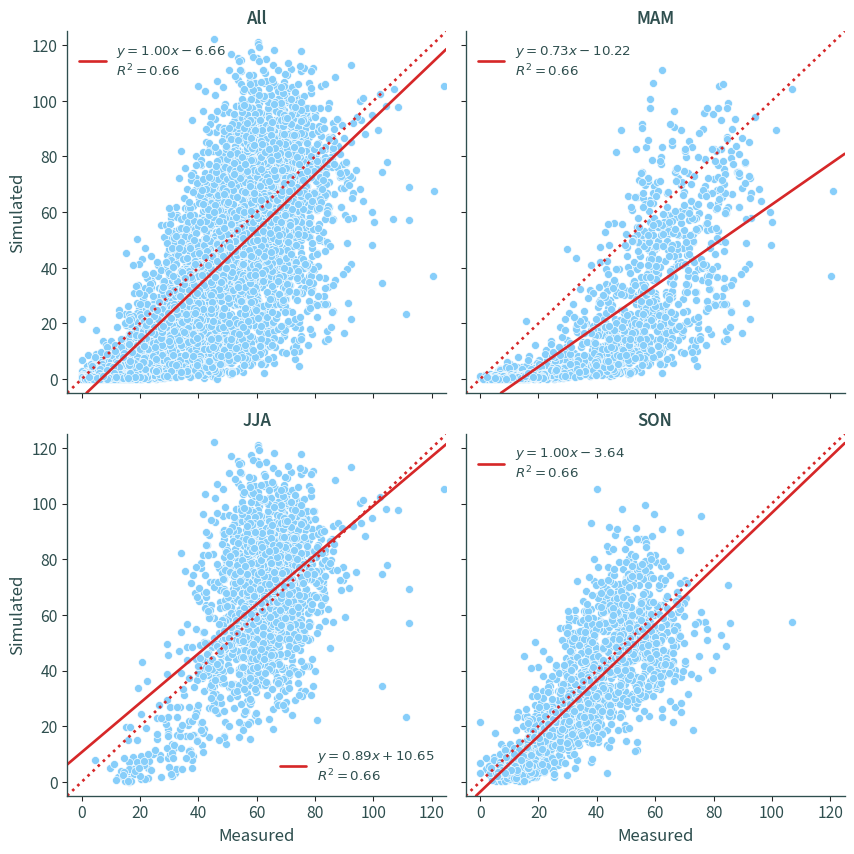

In [249]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(9, 9))
for s, axis in zip(["All", "MAM", "JJA", "SON"], ax.flat):
    df_plt, b, m = get_regression(data_pivot_all, s)
    axis.set_title(s)
    sns.scatterplot(data=df_plt, x="Measured", y="Simulated", color="lightskyblue", ax=axis)
    axis.axline((0, 0), slope=1, color="tab:red", linestyle="dotted", linewidth=2)
    axis.axline((0, b), slope=m, label=f"$y = {m:.2f}x {b:+.2f}$\n$R^2 = {r:.2f}$", color="tab:red", linewidth=2)
    axis.legend(frameon=False, facecolor=None)
    axis.set_xlim([-5, 125])
    axis.set_ylim([-5, 125])
sns.despine()
plt.tight_layout()
plt.show()

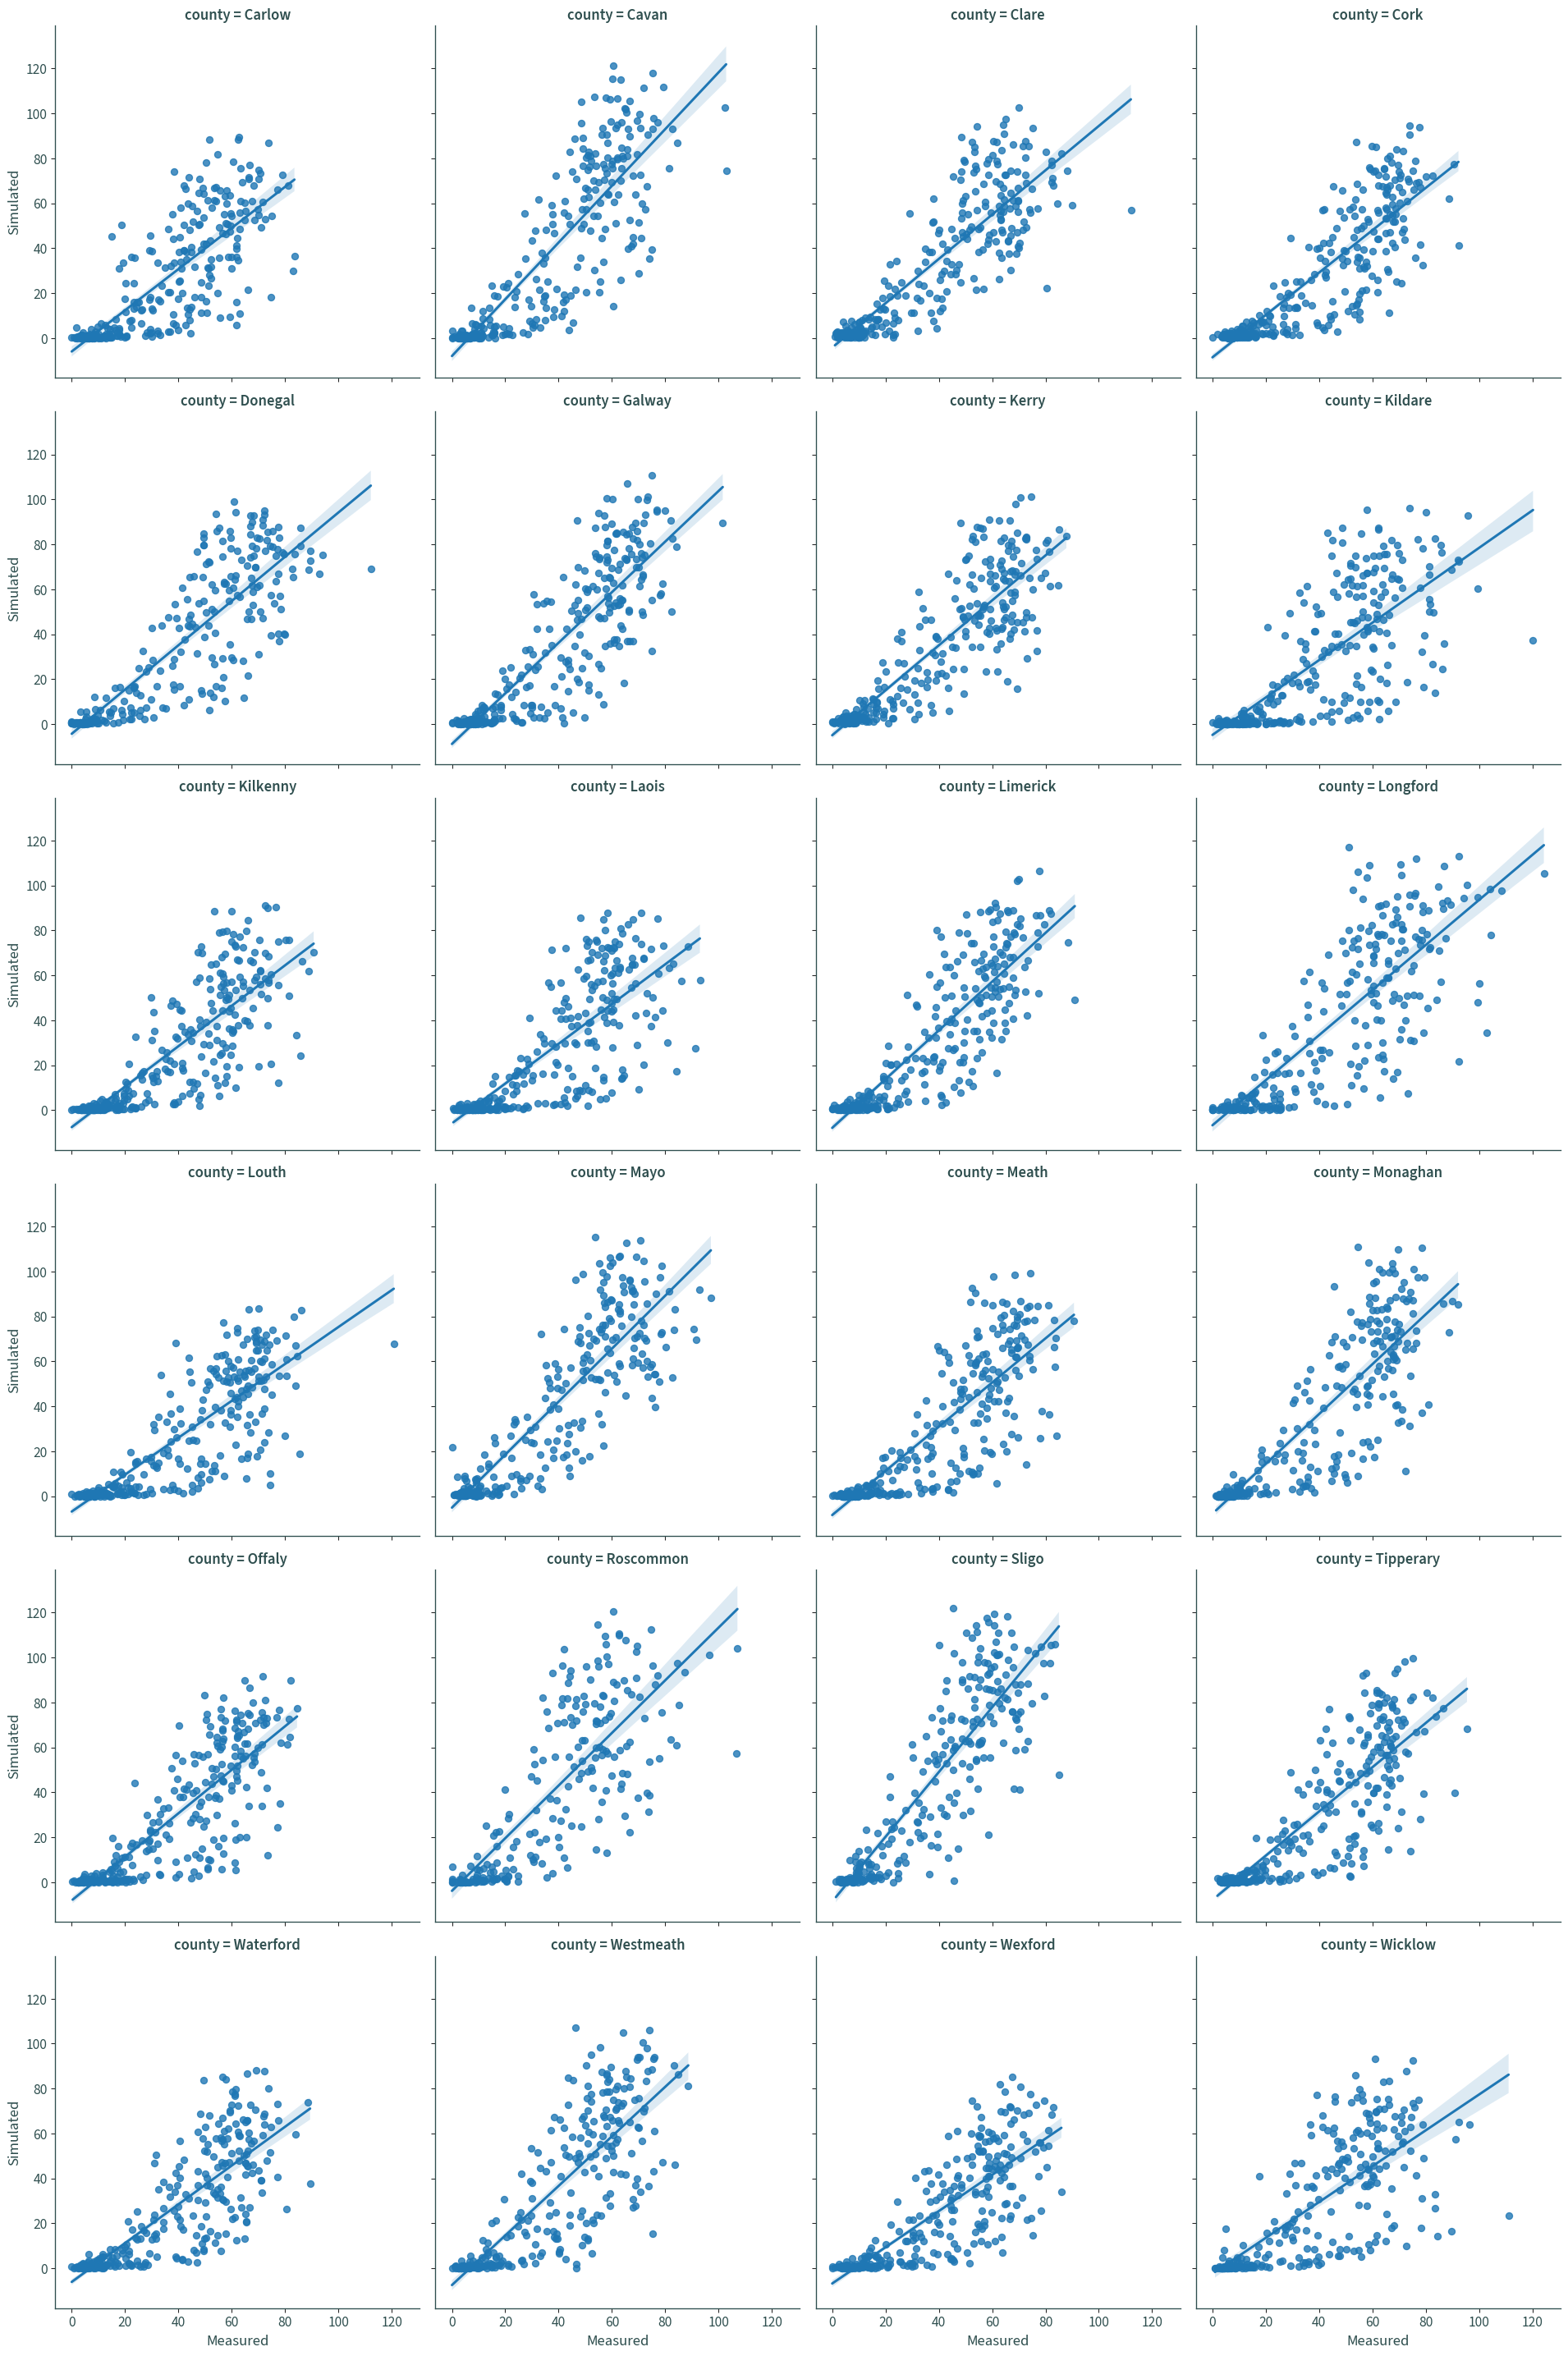

In [124]:
sns.lmplot(data=data_pivot, x="Measured", y="Simulated", col="county", col_wrap=4)
plt.show()